# California

## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [60]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, plot_confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [61]:
# Import the data as a dataframe and save to a variable.
df = pd.read_csv('../data/cleaned_engineered_ca.csv')

In [62]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Santa Clara County, California",23978.0,388.0,0.016181,839764,1922200,495455,615912,45379,3003,...,0.041717,0.679580,0.616108,0.327238,0.056655,0.871549,0.128451,0.469933,0.348772,0.163722
1,"San Mateo County, California",10942.0,159.0,0.014531,285657,765935,189002,303047,16838,1151,...,0.058196,0.604344,0.574618,0.357939,0.067443,0.846114,0.153886,0.430888,0.353295,0.192727


# Regression Modeling

## Explainable Model: GridSearchCV with Quantile, SelectKBest, Ridge: 69%

In [63]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_race_pop_white_alone',    
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',
    'percent_inc_hhlds_35_000_to_49_999',   
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [64]:
# Display the shape of the training  and test data.
X_train.shape, X_test.shape

((43, 19), (15, 19))

In [65]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,20),
    'ridge__alpha': [.1, 1, 10, 20]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [66]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fc5addff700>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10, 20],
                         'selectkbest__k': range(1, 20)},
             scoring='r2')

In [67]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 16}

In [68]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.6929.


In [69]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.7799.


In [70]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:0.7216.


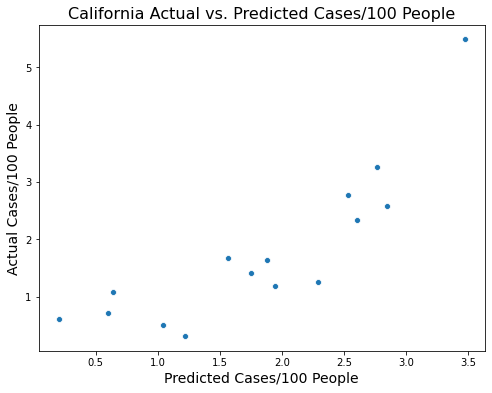

In [71]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('California Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

In [72]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [73]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [74]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [75]:
# Create a dataframe of the features and their coefficients.
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'Coefficients'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='Coefficients', ascending=False)

In [76]:
# Rename the index.
coef_df = coef_df.rename(index={
    'inc_per_capita_inc_dol': 'Income Per Capita ($)',
    'obes_percent': 'Obesity (%)',
    'pop_density': 'Population Density',
    'percent_health_ins_noninst_pop_cov_no': 'Health Insurance: None (%)',
    'percent_sex_age_pop_male': 'Sex: Male (%)',
    'percent_sex_age_pop_under_5': 'Age: Under 5 Yrs (%)',
    'percent_sex_age_pop_5_to_9': 'Age: 5-9 Yrs (%)',
    'percent_sex_age_pop_10_to_14': 'Age: 10-14 Yrs (%)',
    'percent_sex_age_pop_15_to_19': 'Age: 15-19 Yrs (%)',
    'percent_sex_age_pop_20_to_24': 'Age: 20-24 Yrs (%)',
    'percent_sex_age_pop_25_to_34': 'Age: 25-34 Yrs (%)',
    'percent_sex_age_pop_35_to_44': 'Age: 35-44 Yrs (%)',
    'percent_sex_age_pop_45_to_74': 'Age: 45-75 Yrs (%)',
    'percent_sex_age_pop_75_and_over': 'Age: 75+ Yrs (%)',
    'percent_race_pop_asian_alone': 'Race: Asian (%)',
    'percent_race_pop_american_indian_and_alaska_native_alone': 'Race: American Indian/Alaskan (%)',
    'percent_race_pop_black_or_african_american_alone': 'Race: Black/African American (%)',
    'percent_race_pop_hispanic_or_latino_of_any_race': 'Race: Hispanic/Latino (%)',
    'percent_race_pop_two_or_more_races': 'Race: Two or More Races (%)',
    'percent_race_pop_white_alone': 'Race: White (%)',
    'tests_per_100_people': 'Tests/100 People'
})

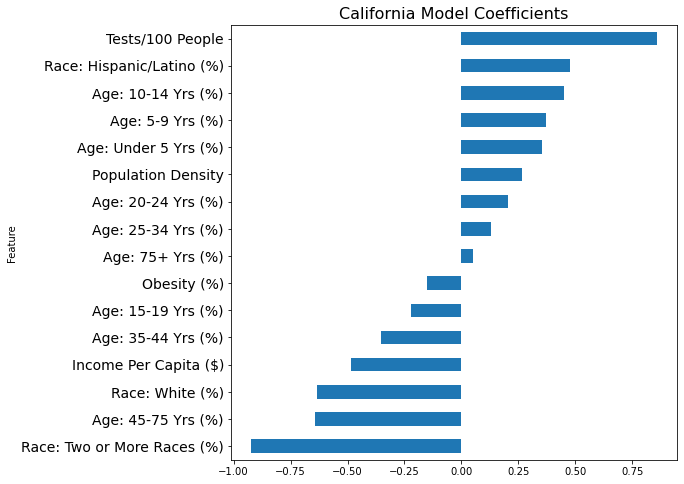

In [77]:
# Plot the datatframe of the features and their coefficients.
coef_df.sort_values(by='Coefficients').plot(kind = 'barh', figsize=(8,8), legend=None)
plt.title('California Model Coefficients', fontsize=16)
plt.yticks(fontsize=14);

## Blackbox Model: Quantile, Polynomial, Gridsearch, Ridge: 72%

In [45]:
# Assign our features to X and y.
X = df[[
    'obes_percent',
    'pop_density',
    'sex_age_median_age_in_years',
    'inc_med_hhld_inc_dol',
    'inc_mean_hhld_inc_dol',
    'inc_per_capita_inc_dol',
    'inc_med_earn_male_full_yr_workers_dol',
    'inc_med_earn_female_full_yr_workers_dol',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'percent_sex_age_pop_male',
    'percent_sex_age_pop_female',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_54',
    'percent_sex_age_pop_55_to_59',
    'percent_sex_age_pop_60_to_64',
    'percent_sex_age_pop_65_to_74',
    'percent_sex_age_pop_75_to_84',
    'percent_sex_age_pop_85_and_over',
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_inc_hhlds_less_than_10_000',
    'percent_inc_hhlds_10_000_to_14_999',
    'percent_inc_hhlds_15_000_to_24_999',
    'percent_inc_hhlds_25_000_to_34_999',
    'percent_inc_hhlds_35_000_to_49_999',
    'percent_inc_hhlds_50_000_to_74_999',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_inc_hhlds_100_000_to_149_999',
    'percent_inc_hhlds_150_000_to_199_999',
    'percent_inc_hhlds_200_000_or_more',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((43, 43), (15, 43))

In [47]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'ridge__alpha': [.1, 1, 10, 20]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [48]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f3182819c20>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10, 20],
                         'selectkbest__k': range(1, 300)},
             scoring='r2')

In [49]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 0.1, 'selectkbest__k': 1}

In [50]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.7211.


In [51]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.7039.


In [52]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:0.6877.


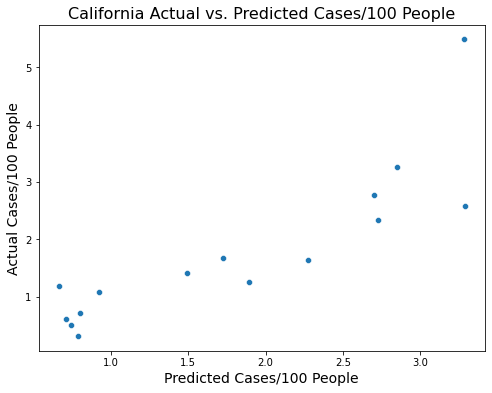

In [53]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('California Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

# Classification Modeling

## Simple Model: GridSearchCV with Classifier: 93% (baseline 66)

In [55]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_race_pop_white_alone',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over'
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [56]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((43, 10), (15, 10))

In [63]:
# Display the baseline percentages.
y_test.value_counts(normalize=True)

1    0.666667
2    0.200000
3    0.133333
Name: covid_severity, dtype: float64

In [59]:
# Create a pipeline.
pipe = make_pipeline(StandardScaler(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [60]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [61]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 0.5, 'selectkbest__k': 4}

In [64]:
# Display the score for the test set.
print(f'Test Accuracy: {round(gs.score(X_test, y_test), 4)}.')

Test Accuracy: 0.9333.


In [65]:
# Display the score for the training set.
print(f'Train Accuracy: {round(gs.score(X_train, y_train), 4)}.')

Train Accuracy: 0.9302.


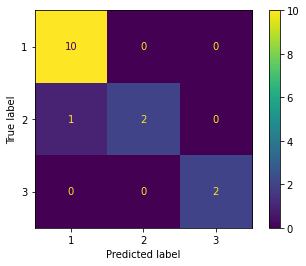

In [66]:
# Plot a confusion matrix.
y_preds = gs.predict(X_test)
plot_confusion_matrix(gs, X_test, y_test);

In [67]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [68]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [69]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [70]:
# Extract coefficients for each class and save to a variable.
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [71]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'Covid Severity Low'])

,Feature,Covid Severity Low
0,percent_race_pop_hispanic_or_latino_of_any_race,-0.962200
1,percent_sex_age_pop_under_5,-0.281539
2,percent_sex_age_pop_10_to_14,-0.394376
3,percent_sex_age_pop_45_to_74,0.772460


In [72]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'Covid Severity Medium'])

,Feature,Covid Severity Medium
0,percent_race_pop_hispanic_or_latino_of_any_race,0.389829
1,percent_sex_age_pop_under_5,-0.434972
2,percent_sex_age_pop_10_to_14,0.008708
3,percent_sex_age_pop_45_to_74,-0.262922


In [73]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'Covid Severity High'])

,Feature,Covid Severity High
0,percent_race_pop_hispanic_or_latino_of_any_race,0.572371
1,percent_sex_age_pop_under_5,0.716511
2,percent_sex_age_pop_10_to_14,0.385669
3,percent_sex_age_pop_45_to_74,-0.509538


# PCA with Regression Model (74%)

In [16]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_race_pop_white_alone',    
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',
    'percent_inc_hhlds_35_000_to_49_999',   
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Display the shape of the training  and test data.
X_train.shape, X_test.shape

((43, 19), (15, 19))

In [49]:
pipe = make_pipeline(PCA(random_state=22), LinearRegression())

In [50]:
#making a pipeline
# pipe = make_pipeline(PCA(random_state=22),
#                      QuantileTransformer(), 
#                      SelectKBest(f_regression), 
#                      Ridge()
#                     )

In [51]:
#setting our params
params = {
    'pca__n_components': [5, 10, 20, 50, 100, 200],
#     'selectkbest__k': range(1,20),
#     'ridge__alpha': [0.01, .1, 1, 10, 20] 
}

In [52]:
# instantiating a GridSearchCV
grid = GridSearchCV(pipe, params, cv=10, n_jobs=-1)

In [53]:
#fitting the model
grid.fit (X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA(random_state=22)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 10, 20, 50, 100, 200]})

In [54]:
grid.score(X_train, y_train)

0.8157707296336569

In [55]:
grid.score(X_test, y_test)

0.7460520607753359

In [56]:
# Calculate the RMSE for the model.
y_preds = grid.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:0.6562.


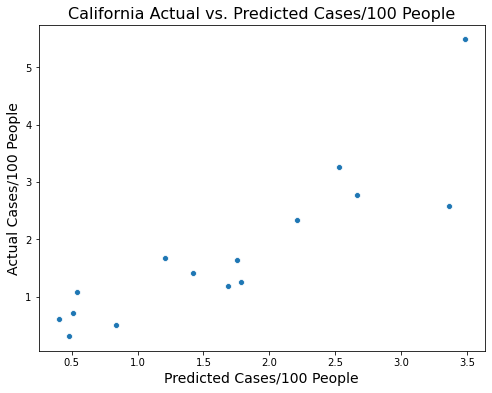

In [57]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('California Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);